<a href="https://colab.research.google.com/github/badhon1512/vision-language-model-VLM/blob/main/florence_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install accelerate
!pip install flash_attn einops timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 54.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.5 MB/s eta 0:00:00
  Created wheel for flash_attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash_attn


In [ ]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForCausalLM
import torch


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = 'microsoft/Florence-2-base'

#load Florence-2 model
model = AutoModelForCausalLM.from_pretrained(model_id, device_map = device, trust_remote_code=True).eval()

processor = AutoProcessor.from_pretrained(model_id, device_map = device, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
img1 = Image.open('seg1.jpg')
img2 = Image.open('seg2.jfif')
img3 = Image.open('depth_image.png')

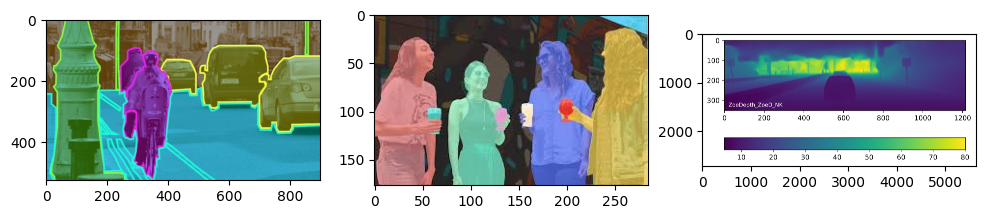

In [ ]:
# display multiple images
rows, cols = 1, 3

plt.figure(figsize=(12, 4))

plt.subplot(rows, cols, 1)
plt.imshow(img1)

plt.subplot(rows, cols, 2)
plt.imshow(img2)
plt.subplot(rows, cols, 3)
plt.imshow(img3)

plt.show()


In [ ]:
def generate_labels(task_prompt, image, text_input=None):

    if image.mode == "RGBA":
        image = image.convert("RGB")
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    output = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return output



In [ ]:
task_prompt = 'Can you say the distance of car from frame'

caption1 = list(generate_labels(task_prompt, img1).values())[0]
caption2 = list(generate_labels(task_prompt, img2).values())[0]


In [ ]:
text_prompt = 'Can you say the distance of car from frame based on depth image?'
task_prompt = '<DETAILED_CAPTION>'

# Call generate_labels and directly access the result (it's a string, not a dictionary)
caption3 = generate_labels(task_prompt, img3)

{'<DETAILED_CAPTION>': 'The image shows a thermal image of a car driving down a road at night, with a blue and green color scheme. The car is illuminated by the light of the moon, and the background is a deep blue. The image also contains text, likely providing further information about the car.'}


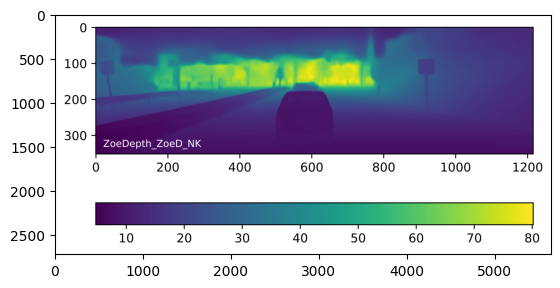

In [ ]:
print(caption3)
plt.imshow(img3);

a group of people standing next to each other holding drinks


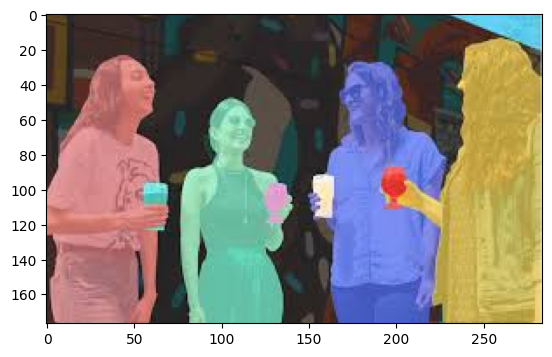

In [ ]:
print(caption2)
plt.imshow(img2);